# 신용카드 정보 Text to SQL Agent

## 데이터 모델링

![ERD Diagram](kb-erd.png)

## Langchain

* Zero shot
* Few shot

## Agentic

* Function
* SQLExecutor

In [3]:
%pip install pyautogen==0.2.32 langchain==0.2.10 langchain_openai==0.1.17 langchain_community==0.2.9 load_dotenv==0.1.0



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import autogen
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain.chains import LLMChain
from langchain_openai import AzureChatOpenAI
import os
from dotenv import load_dotenv

load_dotenv()

db = SQLDatabase.from_uri("sqlite:///kb-creditcard.db")
print (db.dialect)
print(db.get_usable_table_names())




sqlite
['bill', 'bill_add', 'card', 'customer', 'customer_own_card', 'domestic_approve', 'issued_card', 'oversea_approve', 'payment', 'point']


In [17]:

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

In [18]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = create_sql_query_chain(llm, db)

system = """Double check the user's {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Output the final SQL query only.
Don't include markdown or code blocks. 
"""
prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("human", "{query}")]
).partial(dialect=db.dialect)

validation_chain = prompt | llm | StrOutputParser()

full_chain = {"query": chain} | validation_chain



query = full_chain.invoke(
    {
        # "question": "고객들이 가장 많이 사용하는 카드명은 뭐야?"
        "question": "신용카드로 가장 많은 금액을 사용한 업종은 뭐야?"
        # "question": "20대 고객들이 사용하는 카드 중 가장 많이 사용하는 카드명 무엇인가요?"
    }
)

print(query)

db.run(query)
# result[0].get("contents")






SELECT "merchant_name", SUM("approved_amt") AS "total_spent"
FROM "domestic_approve"
WHERE "pay_type" = 'credit'
GROUP BY "merchant_name"
ORDER BY "total_spent" DESC
LIMIT 5;


"[('김김', 540276795.0), ('주식회사 김', 442595386.0), ('(주) 김', 412324340.0), ('(유) 김', 353249695.0), ('유한회사 김', 340566581.0)]"

In [5]:

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

chain = create_sql_query_chain(llm, db)

system = """Double check the user's {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Output the final SQL query only.
Don't include markdown or code blocks. 
"""


few_shot_example = [
    {
        "input": "신용카드로 가장 많은 금액을 사용한 업종은 뭐야", 
        "query": "SELECT prod_type, SUM(paid_amt) AS total_paid_amt FROM bill_add GROUP BY prod_type ORDER BY total_paid_amt DESC LIMIT 1"
    }
]

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt = ChatPromptTemplate.from_messages(
        [
            ("human", "{input}\nSQLQuery:"),
            ("system", "{query}"),
        ],    
    ),  
    examples = few_shot_example, 
)


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system), 
        few_shot_prompt,
        ("human", "{query}")]
).partial(dialect=db.dialect)

validation_chain = prompt | llm | StrOutputParser()

full_chain = {"query": chain} | validation_chain



query = full_chain.invoke(
    {
        # "question": "고객들이 가장 많이 사용하는 카드명은 뭐야?"
        # "question": "신용카드로 가장 많은 금액을 사용한 업종은 뭐야?"
        "question": "20대 고객들이 사용하는 카드 중 가장 많이 사용하는 카드명 무엇인가요?"
    }
)

print(query)

db.run(query)

SELECT "c"."card_name", COUNT("co"."card_no") AS "usage_count"
FROM "customer" AS "cu"
JOIN "customer_own_card" AS "co" ON "cu"."customer_id" = "co"."customer_id"
JOIN "issued_card" AS "ic" ON "co"."card_no" = "ic"."card_no"
JOIN "card" AS "c" ON "ic"."card_id" = "c"."card_id"
WHERE "cu"."age" BETWEEN 20 AND 29
GROUP BY "c"."card_name"
ORDER BY "usage_count" DESC
LIMIT 5;


"[('KB 국민 청춘대로카드', 7), ('KB 국민 다담카드', 7), ('KB 국민 비즈니스카드', 4), ('KB 국민 리브메이트카드', 3), ('KB 국민 와이즈카드', 2)]"

In [19]:

config_list = autogen.config_list_from_json(
    env_or_file="OAI_CONFIG_LIST.json",
)

def run_db(sql):
    result = db.run(sql)
    return result

def create_sql(query):
    return full_chain.invoke({"question": query})
    # result = db.run(q)
    # print(f"query: {q} \n result: {result}")
    # return result

llm_function_config = {
    "config_list": config_list, 
    "stream": True,
    # "seed": 42,
    "functions": [
        {
            "name": "create_sql",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "Create sql to execute on the database"
                    }
                },
                "required": ["query"]
            }
        }, 
        {
            "name": "run_db",
            "description": "run SQL on the database by",
            "parameters": {
                "type": "object",
                "properties": {
                    "sql": {
                        "type": "string",
                        "description": "The sql to execute on the database"
                    }
                },
                "required": ["sql"]
            }
        }

    ]
}



## Autogen SQL Agentic AI 


### SQL Agent
### SQL + Insight + Code Executor Agent (GroupChat)

![sqlagent](./sqlagent.png)

In [20]:
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Human proxy. run the code or SQL, ",
    # llm_config={"config_list": config_list, "stream": True},
    code_execution_config={
        "work_dir": "working",
        "use_docker": False,
    },  
    human_input_mode="NEVER",
    max_consecutive_auto_reply=3,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
)

sql_agent = autogen.AssistantAgent(
  name="chatbot",
  llm_config=llm_function_config,
  system_message="""
    질문 받은 것을 그대로 create_sql Function의 query파라미터에 넣어 SQL을 생성해주세요.
  """,
  human_input_mode="NEVER"
)

user_proxy.register_function(
    function_map={
        "run_db": run_db, 
        "create_sql": create_sql
    }
)

sql_agent.register_function(
    function_map={
        "create_sql": create_sql
    }
)
user_proxy.initiate_chat(sql_agent, message="40대 고객들이 사용하는 카드 중 가장 많이 보유한 카드이름은 무엇인가요?.")


User_proxy (to chatbot):

40대 고객들이 사용하는 카드 중 가장 많이 보유한 카드이름은 무엇인가요?.

--------------------------------------------------------------------------------
chatbot (to User_proxy):


***** Suggested function call: create_sql *****
Arguments: 
{"query":"SELECT card_name FROM card_ownership WHERE age_group = '40s' GROUP BY card_name ORDER BY COUNT(*) DESC LIMIT 1;"}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION create_sql...
User_proxy (to chatbot):

***** Response from calling function (create_sql) *****
SELECT card.card_name
FROM customer
JOIN customer_own_card ON customer.customer_id = customer_own_card.customer_id
JOIN issued_card ON customer_own_card.card_no = issued_card.card_no
JOIN card ON issued_card.card_id = card.card_id
WHERE customer.age BETWEEN 40 AND 49
GROUP BY card.card_name
ORDER BY COUNT(*) DESC
LIMIT 1;
*******************************************************

--

ChatResult(chat_id=None, chat_history=[{'content': '40대 고객들이 사용하는 카드 중 가장 많이 보유한 카드이름은 무엇인가요?.', 'role': 'assistant'}, {'content': '', 'function_call': {'arguments': '{"query":"SELECT card_name FROM card_ownership WHERE age_group = \'40s\' GROUP BY card_name ORDER BY COUNT(*) DESC LIMIT 1;"}', 'name': 'create_sql'}, 'role': 'assistant'}, {'content': 'SELECT card.card_name\nFROM customer\nJOIN customer_own_card ON customer.customer_id = customer_own_card.customer_id\nJOIN issued_card ON customer_own_card.card_no = issued_card.card_no\nJOIN card ON issued_card.card_id = card.card_id\nWHERE customer.age BETWEEN 40 AND 49\nGROUP BY card.card_name\nORDER BY COUNT(*) DESC\nLIMIT 1;', 'name': 'create_sql', 'role': 'function'}, {'content': '', 'function_call': {'arguments': '{"sql":"SELECT card.card_name\\nFROM customer\\nJOIN customer_own_card ON customer.customer_id = customer_own_card.customer_id\\nJOIN issued_card ON customer_own_card.card_no = issued_card.card_no\\nJOIN card ON issued_car

In [9]:

from autogen.coding import LocalCommandLineCodeExecutor

executor_config = LocalCommandLineCodeExecutor(
    timeout=30,  
    work_dir="kb_work_dir", 
    )

insight_agent = autogen.AssistantAgent(
    name="coder_for_insight",
    llm_config=llm_function_config,
    
    system_message="""
        You are Python coder_for_insight. You have to perform only after sql_agent run SQL to query to Database. you will generate code for data analysis and visualization using the result from sql_agent.
        Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
        When visualizing, please save the file as chart.png. If you need a Korean font, use NanumGothic font.
        Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
        If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
    """,
    human_input_mode="NEVER"
)


code_executor = autogen.UserProxyAgent(
    name="Code_executor",

    human_input_mode="NEVER",
    code_execution_config={
        "executor": executor_config
        }
)



In [23]:
groupchat = autogen.GroupChat(agents=[user_proxy, sql_agent, insight_agent, code_executor], messages=[], max_round=20,
                            #   speaker_selection_method=state_transition
                              ) 

groupchat_manager = autogen.GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list, "stream": True})

user_proxy.initiate_chat(groupchat_manager, message="30대 고객이 신용카드를 국내에서 가장 많이 사용한 Top 5 업체정보를 보여주세요" )



User_proxy (to chat_manager):

30대 고객이 신용카드를 국내에서 가장 많이 사용한 Top 5 업체정보를 보여주세요

--------------------------------------------------------------------------------

Next speaker: chatbot

chatbot (to chat_manager):


***** Suggested function call: create_sql *****
Arguments: 
{"query":"SELECT * FROM (SELECT 업체정보, SUM(사용금액) AS 총사용금액 FROM 신용카드사용 WHERE 고객나이 BETWEEN 30 AND 39 AND 사용위치 = '국내' GROUP BY 업체정보 ORDER BY 총사용금액 DESC) WHERE ROWNUM <= 5;"}
***********************************************

--------------------------------------------------------------------------------

Next speaker: chatbot


>>>>>>>> EXECUTING FUNCTION create_sql...
chatbot (to chat_manager):

***** Response from calling function (create_sql) *****
SELECT "merchant_name", SUM("approved_amt") AS "총사용금액"
FROM "domestic_approve" 
JOIN "customer" ON "domestic_approve"."customer_id" = "customer"."customer_id"
WHERE "customer"."age" BETWEEN 30 AND 39
GROUP BY "merchant_name"
ORDER BY "총사용금액" DESC
LIMIT 5;
********************

ChatResult(chat_id=None, chat_history=[{'content': '30대 고객이 신용카드를 국내에서 가장 많이 사용한 Top 5 업체정보를 보여주세요', 'role': 'assistant'}, {'content': '', 'function_call': {'arguments': '{"query":"SELECT * FROM (SELECT 업체정보, SUM(사용금액) AS 총사용금액 FROM 신용카드사용 WHERE 고객나이 BETWEEN 30 AND 39 AND 사용위치 = \'국내\' GROUP BY 업체정보 ORDER BY 총사용금액 DESC) WHERE ROWNUM <= 5;"}', 'name': 'create_sql'}, 'name': 'chatbot', 'role': 'assistant'}, {'content': 'SELECT "merchant_name", SUM("approved_amt") AS "총사용금액"\nFROM "domestic_approve" \nJOIN "customer" ON "domestic_approve"."customer_id" = "customer"."customer_id"\nWHERE "customer"."age" BETWEEN 30 AND 39\nGROUP BY "merchant_name"\nORDER BY "총사용금액" DESC\nLIMIT 5;', 'name': 'create_sql', 'role': 'function'}, {'content': '', 'name': 'Code_executor', 'role': 'user'}, {'content': '', 'function_call': {'arguments': '{"sql":"SELECT \\"merchant_name\\", SUM(\\"approved_amt\\") AS \\"총사용금액\\"\\nFROM \\"domestic_approve\\" \\nJOIN \\"customer\\" ON \\"domestic_approve\\".\\"customer

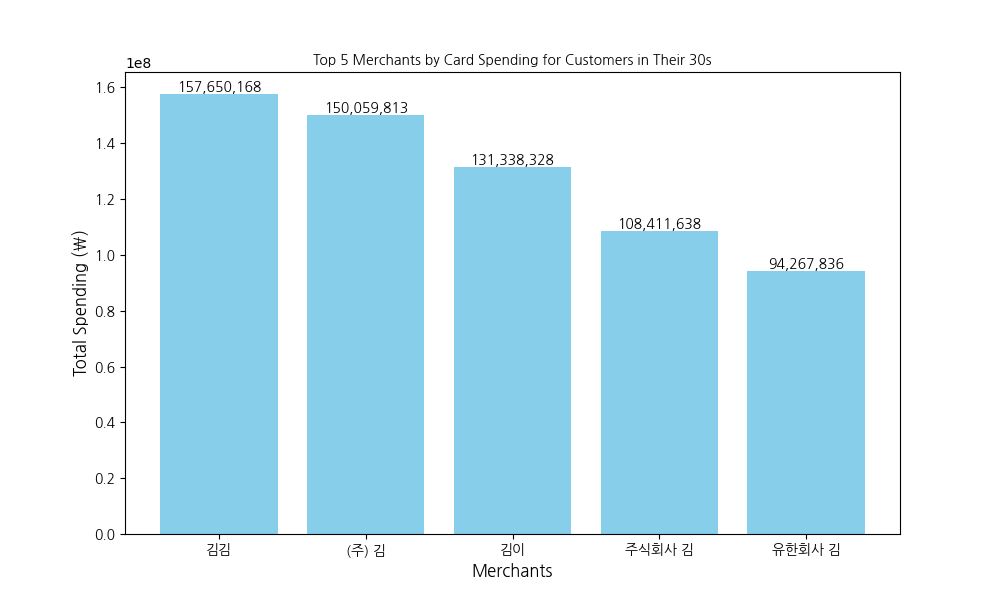

In [24]:
from IPython.display import Image

# Display the image
Image(filename='kb_work_dir/chart.png')

SQL Executor와 Proxy사용 버전은 [여기](./kb-autogen_sql_executor.ipynb)에서 확인할 수 있습니다.